In [1]:
import sys
sys.path.append('../..')

import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import copy
from collections import deque
from skactiveml.classifier import PWC, SklearnClassifier
from skactiveml.pool import RandomSampler, UncertaintySampling, McPAL
from skactiveml.utils import call_func, MISSING_LABEL
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
# random state that is used to generate random seeds
random_state = np.random.RandomState(0)
# number of instances that are provided to the classifier
init_train_length = 10
# the length of the data stream
stream_length = 10000
# the size of the sliding window that limits the training data
training_size = 1000
# define a stream batch size
stream_batch_size = 10
# define a batch size which in the stream enviremont would be a budget
batch_size = 2

In [3]:
def get_randomseed(random_state):
    return random_state.randint(2**31-1)

In [4]:
X, y = sklearn.datasets.make_classification(n_samples=init_train_length + stream_length, random_state=get_randomseed(random_state), shuffle=True)
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]

In [5]:
clf_factory = lambda: PWC(classes=[0,1], random_state=get_randomseed(random_state))
# clf_dict = {'GaussianNaiveBayes' : lambda: SklearnClassifier(GaussianNB(), missing_label=MISSING_LABEL),
#             'DecisionTree' : lambda: SklearnClassifier(DecisionTreeClassifier(), missing_label=MISSING_LABEL),
#             'LinearSVC' : lambda: SklearnClassifier(SVC(probability=True), missing_label=MISSING_LABEL),
#             'PWCWrapped' : lambda: SklearnClassifier(PWC(classes=[0,1]), missing_label=MISSING_LABEL),
#             'PWC' : lambda: PWC(classes=[0,1], random_state=get_randomseed(random_state))}
query_strategies = {
    'RandomSampler': RandomSampler(random_state=get_randomseed(random_state)),
    'UncertaintySampling': UncertaintySampling(random_state=get_randomseed(random_state)),
    'McPAL': McPAL(random_state=get_randomseed(random_state))
}

Query Strategy:  RandomSampler , Avg Accuracy:  0.5225 , Acquisation count: 2000
Query Strategy:  UncertaintySampling , Avg Accuracy:  0.5337 , Acquisation count: 2000
Query Strategy:  McPAL , Avg Accuracy:  0.5347 , Acquisation count: 2000


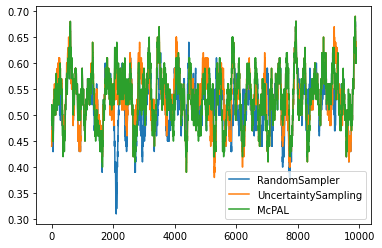

In [6]:
for query_strategy_name, query_strategy in query_strategies.items():
    # for clf_name, clf_factory in clf_dict.items():
    clf = clf_factory()
    # initializing the training data
    X_train = deque(maxlen=training_size)
    X_train.extend(X_init)
    y_train = deque(maxlen=training_size)
    y_train.extend(y_init)
    # train the model with the initially available data
    clf.fit(X_train, y_train)
    # initialize the list that stores the result of the classifier's prediction
    correct_classifications = []
    count = 0
    for t in range(0, len(X_stream), stream_batch_size):
        X_cand = X_stream[t: t + stream_batch_size]
        y_cand_true = y_stream[t: t + stream_batch_size]
        correct_classifications.append(clf.predict(X_cand)[0] == y_cand_true)
        # check whether to sample the instance or not
        # call_func is used since a classifier is not needed for RandomSampler
        sampled_indices = call_func(query_strategy.query, X_cand=X_cand, clf=clf, batch_size=batch_size)
        count += len(sampled_indices)
        X_train.extend(X_cand)
        y_cand = np.full(shape=y_cand_true.shape, fill_value=MISSING_LABEL)
        y_cand[sampled_indices] = y_cand_true[sampled_indices]
        y_train.extend(y_cand)
        # train the classifier
        clf.fit(X_train, y_train)
    # calculate and show the average accuracy 
    print("Query Strategy: ", query_strategy_name, ", Avg Accuracy: ", np.sum(correct_classifications)/stream_length, ", Acquisation count:", count)
    cumsum_correct_classifications = np.cumsum(correct_classifications)
    # smoothing the accuracy for plotting
    smoothing_window_length = 100
    plt.plot((cumsum_correct_classifications[smoothing_window_length:]-cumsum_correct_classifications[:-smoothing_window_length])/smoothing_window_length, label=query_strategy_name)
plt.legend()